In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv').dropna(subset=['Text'])

print(len(df.index))
df['Text'].head()


104806


0    @PabloGomez1968 @Mx_Diputados 2. Como el cánce...
1    RT @MarcusSaemann: The beneficial short‐term e...
2    @valee_noro A mi según solo me van a heredar l...
3    RT @cuidardiabetes: 📆Hace 100 años un día como...
4    RT @josueordonezl: Estimado @JorgeWated saludo...
Name: Text, dtype: object

In [3]:
import preprocessor as p

df['clean_text'] = df['Text'].apply(lambda text: p.clean(str(text)))

df['clean_text'].head()

0    . Como el cncer, la diabetes, la insuficiencia...
1    : The beneficial shortterm effects of a highpr...
2          A mi segn solo me van a heredar la diabetes
3    : Hace aos un da como hoy comenzaban los exper...
4    : Estimado saludos cordiales, por favor ayudem...
Name: clean_text, dtype: object

In [4]:
df.sort_values("Text", inplace = True)
# dropping ALL duplicte values
df.drop_duplicates(subset ="Text",keep = False, inplace = True)

In [5]:
df['clean_text'] = df['clean_text'].apply(lambda text: text.lower())

df['clean_text'].head()

86155                  ! lose weight fast without exercise
1990     ! ya estamos en vivo!sintoniza por en san este...
64567    !urgent!need a+ blood grouprequirement date:- ...
42760                                                  " "
53069    " aww , but that blush of yours just makes you...
Name: clean_text, dtype: object

In [6]:
import re

def remove_contractions(text):
    text = re.sub(r'’', '\'', text)
    
    text = re.sub(r'won\'t', 'will not', text)
    text = re.sub(r'can\'t', 'can not', text)
    
    text = re.sub(r'\'s', ' is', text)
    text = re.sub(r'\'m', ' am', text)
    text = re.sub(r'\'re', ' are', text)
    text = re.sub(r'\'ve', ' have', text)
    text = re.sub(r'\'ll', ' will', text)
    text = re.sub(r'\'d', ' would', text)
    text = re.sub(r'\'t', ' not', text)
    text = re.sub(r'n\'t', ' not', text)
    
    return text

df['clean_text'] = df['clean_text'].apply(remove_contractions)

df['clean_text'].head()

86155                  ! lose weight fast without exercise
1990     ! ya estamos en vivo!sintoniza por en san este...
64567    !urgent!need a+ blood grouprequirement date:- ...
42760                                                  " "
53069    " aww , but that blush of yours just makes you...
Name: clean_text, dtype: object

In [7]:
df['clean_text'] = df['clean_text'].str.replace('[^\w\s]', '')

df['clean_text'].head()

<ipython-input-7-5c51cfc4f7e5>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_text'] = df['clean_text'].str.replace('[^\w\s]', '')


86155                    lose weight fast without exercise
1990      ya estamos en vivosintoniza por en san esteba...
64567    urgentneed a blood grouprequirement date th ma...
42760                                                     
53069     aww  but that blush of yours just makes you a...
Name: clean_text, dtype: object

In [8]:
# Remove whitespaces.

df['clean_text'] = df['clean_text'].apply(lambda text: str(text).strip())

df['clean_text'].head()

86155                    lose weight fast without exercise
1990     ya estamos en vivosintoniza por en san esteban...
64567    urgentneed a blood grouprequirement date th ma...
42760                                                     
53069    aww  but that blush of yours just makes you a ...
Name: clean_text, dtype: object

In [9]:
# Remove empty texts.

df = df.drop(df[df['clean_text'] == ''].index)

print(len(df.index))
df['clean_text'].head()

43097


86155                    lose weight fast without exercise
1990     ya estamos en vivosintoniza por en san esteban...
64567    urgentneed a blood grouprequirement date th ma...
53069    aww  but that blush of yours just makes you a ...
75105    you probably know on some level that what diet...
Name: clean_text, dtype: object

In [10]:
# Remove non-English words.
from nltk.corpus import words
words = set(words.words())

df['clean_text'] = df['clean_text'].apply(lambda text: ' '.join(word for word in text.split() if word in words))

df['clean_text'].head()

86155                    lose weight fast without exercise
1990                                 ya en en san mas loma
64567             a blood date th may location is diabetes
53069    but that blush of yours just you a thousand ti...
75105    you probably know on some level that what of y...
Name: clean_text, dtype: object

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(df['clean_text']))

In [13]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) 
   if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

In [15]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

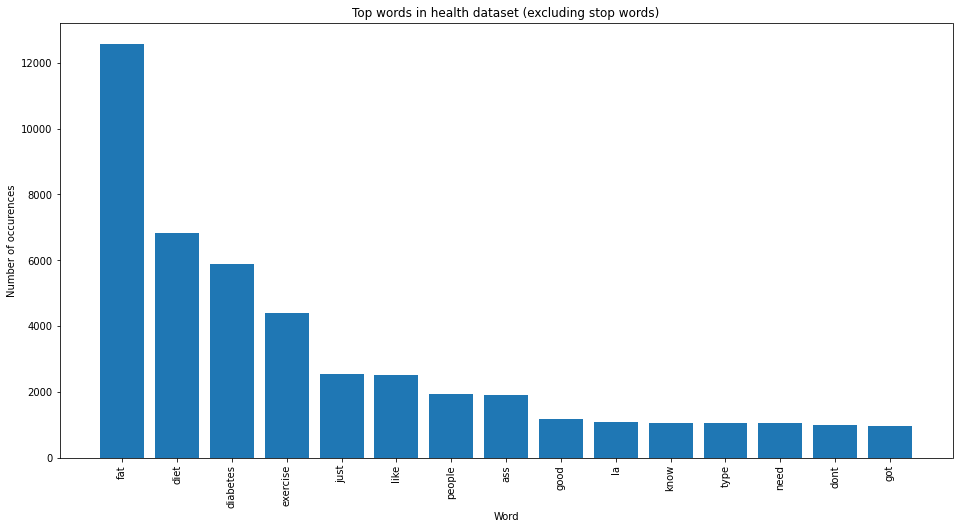

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in health dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [18]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [19]:
lsi_model = gensim.models.lsimodel.LsiModel(
   corpus=corpus, id2word=id2word, num_topics=50,chunksize=100
)

In [20]:
pprint(lsi_model.print_topics())
doc_lsi = lsi_model[corpus]

[(0,
  '0.949*"fat" + 0.159*"ass" + 0.144*"get" + 0.071*"diet" + 0.063*"people" + '
  '0.061*"big" + 0.056*"do" + 0.055*"go" + 0.045*"eat" + 0.042*"say"'),
 (1,
  '0.922*"diet" + 0.150*"get" + -0.145*"fat" + 0.130*"exercise" + 0.114*"eat" '
  '+ 0.087*"go" + 0.079*"coke" + 0.066*"good" + 0.058*"do" + 0.057*"day"'),
 (2,
  '0.798*"exercise" + 0.349*"get" + -0.274*"diet" + 0.270*"diabete" + '
  '-0.108*"fat" + 0.083*"people" + 0.080*"go" + 0.076*"do" + 0.076*"good" + '
  '0.059*"time"'),
 (3,
  '-0.849*"diabete" + 0.428*"exercise" + -0.188*"get" + -0.155*"type" + '
  '-0.097*"diabetes" + -0.072*"risk" + -0.069*"people" + 0.044*"diet" + '
  '0.039*"fat" + -0.028*"know"'),
 (4,
  '-0.881*"get" + 0.320*"diabete" + 0.289*"exercise" + 0.100*"fat" + '
  '0.080*"diet" + 0.067*"people" + 0.066*"type" + 0.035*"risk" + 0.029*"eat" + '
  '0.025*"health"'),
 (5,
  '-0.691*"people" + -0.396*"diabetes" + -0.243*"eat" + 0.242*"diabete" + '
  '-0.207*"do" + 0.170*"ass" + 0.166*"exercise" + -0.160*"type"

In [21]:
#print('\nPerplexity: ', lsi_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)


Coherence Score:  0.26113315583947405


In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.lsimodel.LsiModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=500, step=20)

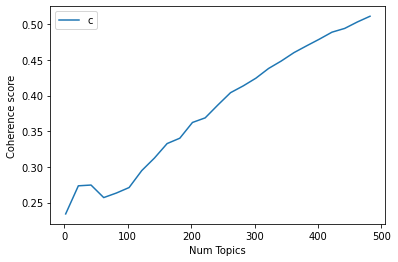

In [29]:
limit=500; start=2; step=20;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2342
Num Topics = 22  has Coherence Value of 0.2735
Num Topics = 42  has Coherence Value of 0.2746
Num Topics = 62  has Coherence Value of 0.257
Num Topics = 82  has Coherence Value of 0.2634
Num Topics = 102  has Coherence Value of 0.2711
Num Topics = 122  has Coherence Value of 0.2949
Num Topics = 142  has Coherence Value of 0.3125
Num Topics = 162  has Coherence Value of 0.3328
Num Topics = 182  has Coherence Value of 0.3403
Num Topics = 202  has Coherence Value of 0.3623
Num Topics = 222  has Coherence Value of 0.3688
Num Topics = 242  has Coherence Value of 0.3868
Num Topics = 262  has Coherence Value of 0.4041
Num Topics = 282  has Coherence Value of 0.4136
Num Topics = 302  has Coherence Value of 0.4244
Num Topics = 322  has Coherence Value of 0.438
Num Topics = 342  has Coherence Value of 0.4484
Num Topics = 362  has Coherence Value of 0.4602
Num Topics = 382  has Coherence Value of 0.4697
Num Topics = 402  has Coherence Value of 0.479
N

In [26]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.949*"fat" + 0.160*"ass" + 0.144*"get" + 0.071*"diet" + 0.063*"people" + '
  '0.061*"big" + 0.055*"do" + 0.055*"go" + 0.044*"eat" + 0.042*"say"'),
 (1,
  '0.922*"diet" + 0.150*"get" + -0.144*"fat" + 0.129*"exercise" + 0.113*"eat" '
  '+ 0.087*"go" + 0.079*"coke" + 0.066*"good" + 0.057*"do" + 0.057*"day"'),
 (2,
  '0.793*"exercise" + 0.351*"get" + 0.284*"diabete" + -0.273*"diet" + '
  '-0.108*"fat" + 0.083*"people" + 0.080*"go" + 0.076*"do" + 0.076*"good" + '
  '0.058*"time"'),
 (3,
  '-0.854*"diabete" + 0.433*"exercise" + -0.171*"get" + -0.148*"type" + '
  '-0.094*"diabetes" + -0.069*"risk" + -0.065*"people" + 0.038*"diet" + '
  '0.035*"fat" + -0.027*"la"'),
 (4,
  '-0.884*"get" + 0.310*"diabete" + 0.296*"exercise" + 0.101*"fat" + '
  '0.082*"diet" + 0.062*"people" + 0.059*"type" + 0.033*"risk" + 0.026*"eat" + '
  '0.024*"good"'),
 (5,
  '-0.672*"people" + -0.426*"diabetes" + -0.237*"eat" + 0.234*"diabete" + '
  '-0.205*"do" + 0.189*"ass" + -0.169*"type" + 0.164*"exercise" + -